The purpose of this project is to model stock prices and understand a company's performance through a Capital Asset Pricing Model. 

In [225]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [226]:
df = pd.read_csv('S&P_Modeling.csv')

In [227]:
df.head(2)

,dates,share_price_company,s&p_400_price,company_rfr,s&p_400_rfr
0,Mar-31-2016,131.86,1445.19,NaN,NaN
1,Apr-30-2016,120.88,1461.65,0.0183,0.0183


In [228]:
df.dtypes

dates                   object
share_price_company    float64
s&p_400_price          float64
company_rfr            float64
s&p_400_rfr            float64
dtype: object

In [229]:
df['dates'] = pd.to_datetime(df['dates'])
df = df.sort_values(by=['dates']).reset_index()
#df.head(2)
df=df.drop(columns='index')

In [230]:
#Calculating Returns (running row calc % change)
df['company_returns'] = (df['share_price_company']- df['share_price_company'].shift(1))/ df['share_price_company'].shift(1)

In [231]:
df['s&p_returns'] = (df['s&p_400_price']-df['s&p_400_price'].shift(1))/df['s&p_400_price'].shift(1)

In [232]:
df.rename(columns={'company_rfr': 'rfr'}, inplace=True)
df.drop('s&p_400_rfr', axis=1, inplace=True)


In [233]:
df['company_excess']= df['rfr']-df['company_returns']

df['s&p_excess']= df['rfr']- df['s&p_returns']

In [234]:
df=df.dropna()
df.head(2)

,dates,share_price_company,s&p_400_price,rfr,company_returns,s&p_returns,company_excess,s&p_excess
1,2016-04-30,120.88,1461.65,0.0183,-0.08327,0.011390,0.10157,0.006910
2,2016-05-31,120.88,1493.05,0.0184,0.00000,0.021483,0.01840,-0.003083


In [235]:
#since company vs S&P are vastly different, will normalize price values
def normalize(df, column_indices):
    """
    Normalize specified columns of a DataFrame by dividing by the first value in each column.
    """
    x = df.copy()  # Create a copy of the DataFrame
    
    for i in column_indices:  # Iterate over specified column indices
        if i >= len(x.columns):
            raise IndexError(f"Column index {i} is out of range.")
        if x.iloc[0, i] == 0:
            raise ValueError(f"Cannot normalize column {i} because its first value is zero.")
        
        x.iloc[:, i] = x.iloc[:, i] / x.iloc[0, i]  # Normalize the column
        
    return x


In [236]:
# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['dates'], y = df[i], name = i)
  fig.show()

In [237]:
#use the interactive plot
(interactive_plot(df, 'Prices'))

In [238]:
normalized_df = normalize(df, column_indices=[1, 2])
interactive_plot(normalized_df, 'Normalized Prices')


# Calculating BETA
* understanding the risk of a stock relative to the market. Beta measures the volatility or risk of a stock compared to the market as a whole

In [239]:
# Calculate covariance and variance
cov_matrix = np.cov(df['company_returns'], df['s&p_returns'])
cov_stock_market = cov_matrix[0, 1]
var_market = cov_matrix[1, 1]

# Calculate beta
beta = cov_stock_market / var_market

print(f"Beta: {beta:.4f}")

Beta: 0.2819


A beta of 0.28 represents a relatively low level of volatility or risk compared to the market.

Visual Representation of calculating beta:

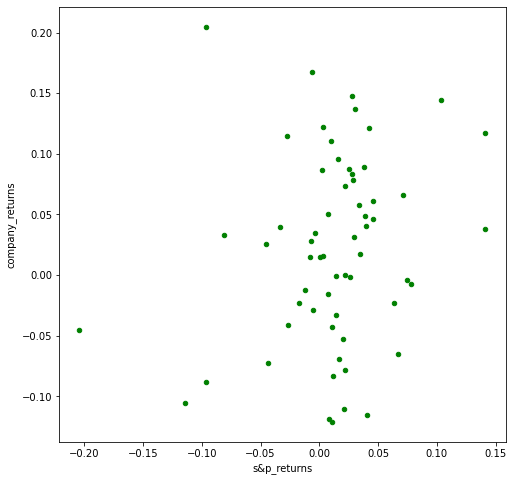

In [240]:
# plot a scatter plot between the  stock and the S&P400 (Market)
df.plot(kind = 'scatter', x = 's&p_returns', y = 'company_returns',figsize=(8, 8),color='green')
plt.show()


In [241]:
# beta represents the slope of the line regression line (market return vs. stock return). 
# Beta is used in the CAPM and describes the relationship between systematic risk and expected return for assets 
beta, alpha = np.polyfit(df['s&p_returns'], df['company_returns'], 1)
print('Beta for {} stock is = {} and alpha is = {}'.format('company_returns', round(beta,3), round(alpha,3)))  

Beta for company_returns stock is = 0.282 and alpha is = 0.018


# CAPM Assessment

In [242]:
beta

0.2818644008013226

In [243]:
avg_company_returns = df.company_returns.mean()

avg_company_returns

0.021076201161168588

In [244]:
avg_market_returns = df['s&p_returns'].mean()
avg_market_returns

0.011607123697509407

In [245]:
df.tail()

,dates,share_price_company,s&p_400_price,rfr,company_returns,s&p_returns,company_excess,s&p_excess
57,2020-12-31,383.46,2306.62,0.0093,-0.023206,0.063694,0.032506,-0.054394
58,2021-01-31,370.76,2340.12,0.0111,-0.033119,0.014523,0.044219,-0.003423
59,2021-02-28,346.51,2496.26,0.0144,-0.065406,0.066723,0.079806,-0.052323
60,2021-03-31,367.79,2609.24,0.0174,0.061412,0.045260,-0.044012,-0.027860
61,2021-04-21,394.80,2666.77,0.0158,0.073439,0.022049,-0.057639,-0.006249


In [246]:
#using a 10-year treasury bond in April 2021 was around 1.75%
rfr = .0175

In [247]:
#Market Risk Premium = Expected s&p returns - rfr
market_risk_premium = avg_market_returns-rfr
market_risk_premium

-0.005892876302490595

In [248]:
#Cost of Equity from CAPM = rfr + beta*(Market Risk Premium)
CAPM_cost_of_equity = rfr + beta*(market_risk_premium)
print(f"CAPM Cost of Equity: {CAPM_cost_of_equity*100:.2f}%")

CAPM Cost of Equity: 1.58%
